# Visualizing TF-IDF Weighted W2V on Amazon Fine Food Review Dataset

#### 1.Import statements

In [7]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

# !pip install -U gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import re
import os


from tqdm import tqdm

#### 2. Connecting to the Database file using pandas library and retriving the data from 'CleanedText' column

* This Data is the result of the data pre-processing in the 'Data Pre-processing for t-SNE on Amazon Review Dataset.ipynb' file on the Amazon Fine Food Review Dataset. The review data from the original dataset is processed(cleaned) and stored in the same db file for further use.



In [8]:
#Access reviews data from 'final.sqlite' file
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

 ####   3. Dimensionality reduction of the TF-IDF weighted W2V Vectors for Review text using t-SNE in Scikit-Learn
 
* Steps:
    1) Get all the sentences from the 'CleanedText' field and split them as list of sentences.
    
    2) Convert all the list of sentences to Word2Vec using Word2Vec from gensim.models module. The parameters used are as follows:
        a) list_of_sent/sentences: list of lists of sentences.
        b) min_count: Ignores all words with total frequency lower than min_count. Ex: min_count = 5.
        c) size: Dimensionality of the resulting word vectors. Ex: size=50.
        d) workers: no. of worker threads to train the model(=faster training with multicore machines). Ex: workers=14.
     
     3) Convert all the sentences from the 'CleanedText' to TF-IDF vectors
     
     4) Once both these values are obtained the following is done:
        a) Get the w2c vector for a word.
        b) Get the TF-IDF vector of the same word and multiply this with the w2v.
        c) Add all the TF-IDF wighted W2V and then divide the each vector from last step with the sum to get the TF-IDF weighted W2V vector as end result.
      
     5) After obtaining the result from the above step, get the first 30000 datapoints from the dataset and apply dimensionality reduction using t-SNE and plot the points in 2D.

In [11]:
# Training your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [12]:
# min_count = 5, considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=14)

In [13]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  21938
sample words  ['hurrah', 'dallmayr', 'pepermint', 'chines', 'hart', 'liqueur', 'teeccino', 'mellita', 'homecook', 'scudder', 'quinci', 'viscos', 'honolulu', 'xango', 'viet', 'parisienn', 'site', 'tuck', 'trick', 'slam', 'ref', 'frighten', 'unaffect', 'consumeraffair', 'malleabl', 'brillianc', 'hostess', 'nauseat', 'rephras', 'snob', 'symptomat', 'specialti', 'rice', 'milder', 'gephardt', 'xxxxtra', 'rig', 'fend', 'tahina', 'inflat', 'kellogg', 'energ', 'roomat', 'surreal', 'infer', 'analys', 'ane', 'jivealim', 'cherish', 'mei']


In [14]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [15]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sent = list_of_sent[0:30000]
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1



100%|██████████| 30000/30000 [11:39<00:00, 42.86it/s]


<class 'list'>


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



* At this point we'll get the list of TF-IDF sentence vectors and we'll use this for t-SNE

#### 4. Plotting TF-IDF Weighted W2V vectors using Seaborn

364171
30000


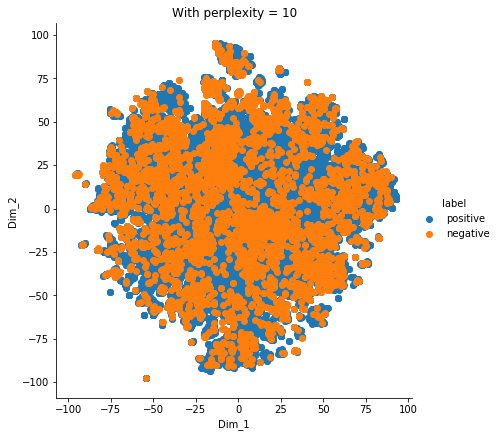

In [16]:
# from sklearn.manifold import TSNE
top_5000 = tfidf_sent_vectors
labels = final['Score']
print(len(labels))
labels_5000 = labels[0:30000]
print(len(labels_5000))


from sklearn.preprocessing import StandardScaler
sc = StandardScaler(copy=True, with_mean=False, with_std=True)
top_5000 = sc.fit_transform(top_5000)



from MulticoreTSNE import MulticoreTSNE as TSNE

tsne_model = TSNE(n_jobs = 14, n_components=2, random_state=0, perplexity=10, n_iter=5000)
tsne_data = tsne_model.fit_transform(top_5000)


# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.title('With perplexity = 10')
plt.show()

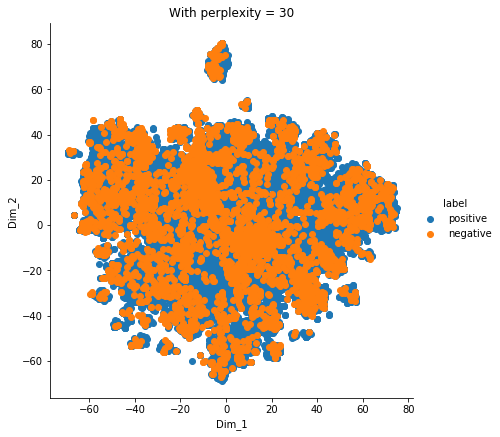

In [17]:
tsne_model = TSNE(n_jobs = 14, n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_data = tsne_model.fit_transform(top_5000)


# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.title('With perplexity = 30')
plt.show()


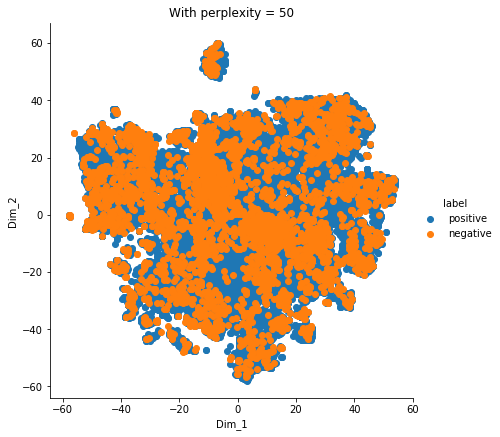

In [18]:
tsne_model = TSNE(n_jobs = 14, n_components=2, random_state=0, perplexity=50, n_iter=5000)
tsne_data = tsne_model.fit_transform(top_5000)


# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.title('With perplexity = 50')
plt.show()

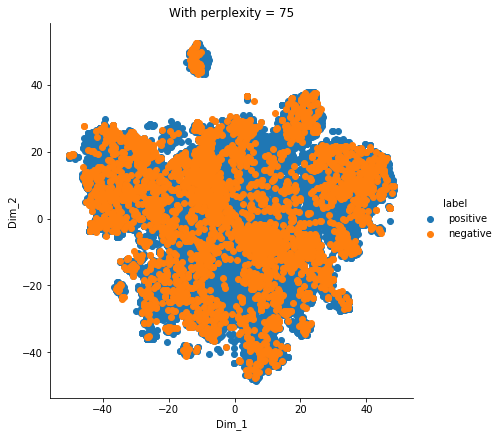

In [19]:
tsne_model = TSNE(n_jobs = 14, n_components=2, random_state=0, perplexity=75, n_iter=5000)
tsne_data = tsne_model.fit_transform(top_5000)


# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.title('With perplexity = 75')
plt.show()

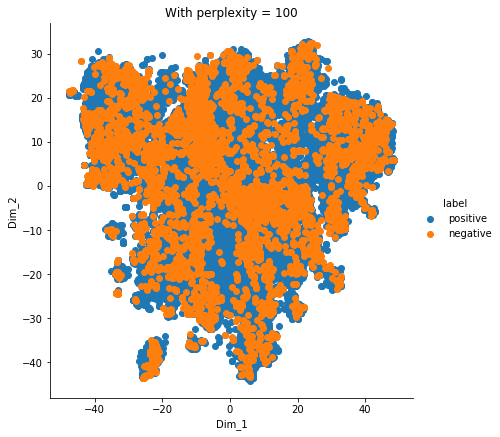

In [20]:
tsne_model = TSNE(n_jobs = 14, n_components=2, random_state=0, perplexity=100, n_iter=5000)
tsne_data = tsne_model.fit_transform(top_5000)


# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_5000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.title('With perplexity = 100')
plt.show()

# Observations:

* At first glance all the graphs are different in their overall shape and clustering is very good compared to all the previous techniques but the positive and negative points grouping suffers a lot of overlap between them.

* Eventhough TF-IDF weighted W2V considers the semantic meaning of the words, there are lot of words that are common between the positive and the negative reviews and also the dimensionality has been reduced from 50-D to 2-D which gives us the overlapped plot.

* TF-IDF weighted W2V can be considered as the overall well clustered data visualization plot because a very few points are scattered across the plot and all of points in the plot belonging to a class stayed really close to cluster.

* As the perplexity increased in the different plots, the shape of the plot also has changed due to more number of similar points are trying to be closer as a group. This is pronounced more in TF-IDF weighted W2V than in others.